In [307]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
#!pip install pygam
from pygam import LinearGAM

In [266]:
# load in dataset
# read in UK t2m & NAO data
df = pd.read_csv("country_data/ERA5_hourly_UK.csv")
df.columns = ["date_time","t2m","ssrd","msl","nao", "w10","w100"]
df.head()

,date_time,t2m,ssrd,msl,nao,w10,w100
0,1979-01-01 00:00:00,-5.702784,-32767.0,1014.010319,-1.38,0.539450,1.686726
1,1979-01-01 01:00:00,-5.507162,-32767.0,1014.724101,-1.38,0.756348,1.752340
2,1979-01-01 02:00:00,-5.664224,-32767.0,1015.209416,-1.38,1.106655,2.131312
3,1979-01-01 03:00:00,-5.944852,-32767.0,1015.758926,-1.38,1.299900,2.487398
4,1979-01-01 04:00:00,-5.952020,-32767.0,1015.954954,-1.38,1.383135,2.694151


In [267]:
# add week
df["week"] = pd.to_numeric(pd.to_datetime(df.date_time).dt.strftime("%U"))

# Preprocessing

### Split Train/test

In [268]:
# calculate daily values
df.date_time = pd.to_datetime(df.date_time)
df_daily = df.groupby(df.date_time.dt.date).mean()
df_daily["t2mmax"] = t2mmax = df.t2m.groupby(df.date_time.dt.date).max()
df_daily["t2mmin"] = df.t2m.groupby(df.date_time.dt.date).min()

# set X equal to df_daily
X = df_daily

In [269]:
# create 24-hour t2m arrays as target variable
Y_list = []
for i in range(int(len(df)/24)):
    Y_list.append(df.t2m.iloc[(i*24):(i*24+24)].values)
Y = np.array(Y_list)

# add date_time index
y = pd.DataFrame(Y,index=df_daily.index)

### Visualization of independent vars

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f958ecd80f0>,
      dtype=object)

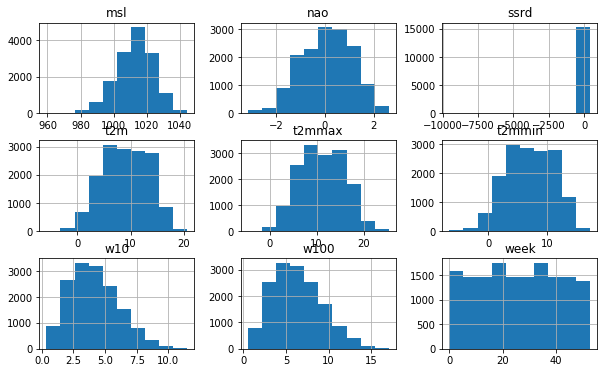

In [6]:
X.hist(figsize=(10,6))

Mostly normal distributions of variables of interest, except ssrd. 

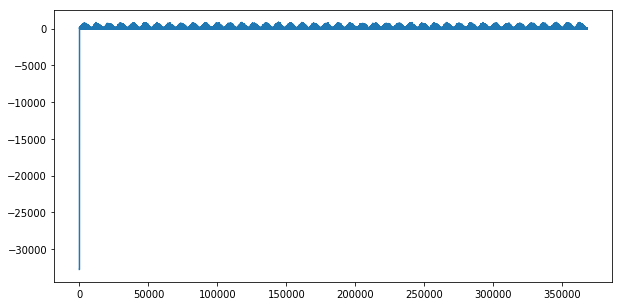

In [9]:
df.ssrd.plot(figsize=(10,5))

Remove outlier from ssrd.

/opt/jaspy/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


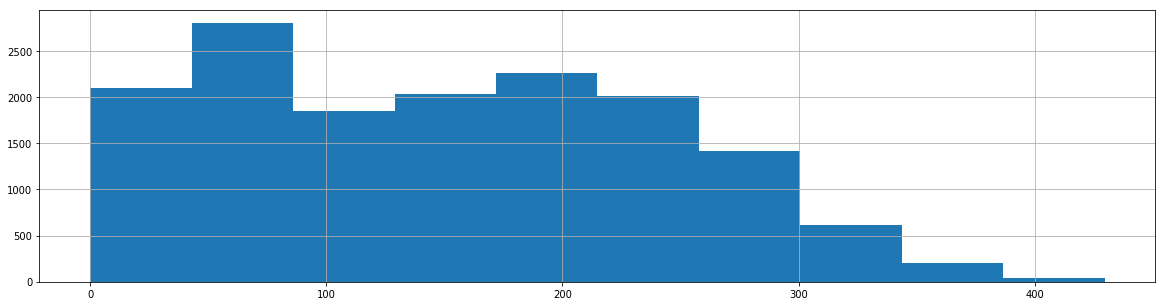

In [270]:
# remove outliers
X.ssrd[X.ssrd<-5000]=0

# produce ssrd plot
X.ssrd.hist()

Split train/test

In [275]:
# split train/test 70/30
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state = 10,shuffle=False)

# create a dataframe of the hours for plotting purposes
X_test.index = pd.to_datetime(X_test.index)
X_test_hours = X_test.resample("1H").pad().index

### Modeling

Linear Regression

In [276]:
from sklearn.linear_model import LinearRegression

# produce linear regression
reg = LinearRegression().fit(X_train, y_train)
pred_reg = reg.predict(X_test)

In [302]:
# metrics
r2_reg = r2_score(y_test,pred_reg)
mae_reg = mean_absolute_error(y_test,pred_reg)

print("R2-score: ",r2_reg)
print("MAE-score: ",mae_reg)

R2-score:  0.9788673538277753
MAE-score:  0.4251066266580952


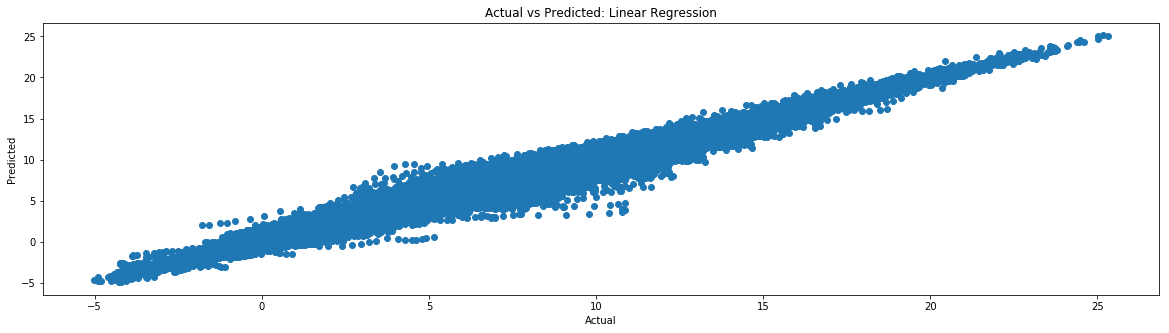

In [278]:
# plot results
plt.scatter(y_test.values.flatten(),pred_reg.flatten())
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted: Linear Regression")
plt.rcParams["figure.figsize"] = (20,5)

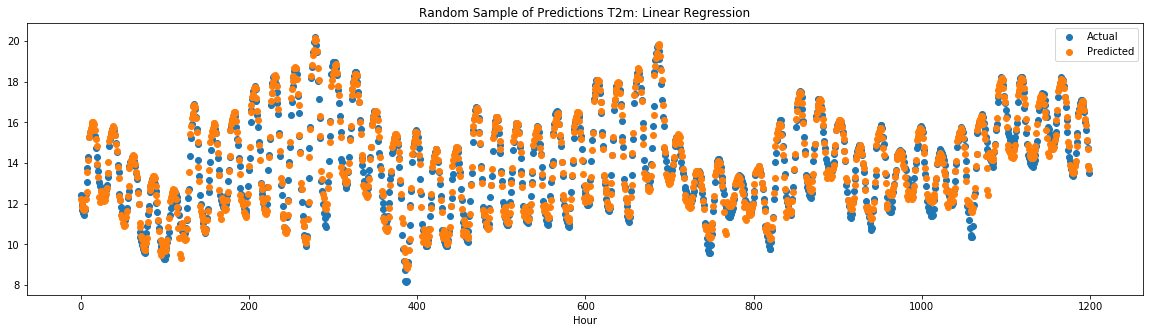

In [189]:
plt.scatter(np.arange(0,50*24,1),y_test.values[300:350])
plt.scatter(np.arange(0,50*24,1),pred_reg[300:350])
plt.xlabel("Hour")
plt.title("Random Sample of Predictions T2m: Linear Regression")
plt.legend(["Actual","Predicted"])

### Random Forest

In [190]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=60).fit(X_train,y_train)
pred_rf = rf.predict(X_test)

In [303]:
# metrics
r2_rf = r2_score(y_test,pred_rf)
mae_rf = mean_absolute_error(y_test,pred_rf)

print("R2-score: ",r2_rf)
print("MAE-score: ",mae_rf)

R2-score:  0.9809775904967858
MAE-score:  0.3893844570359304


Text(0, 0.5, 'MSE')

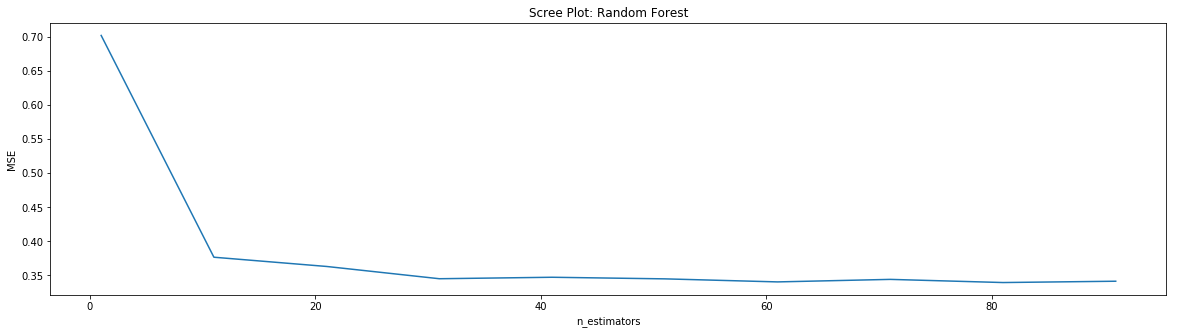

In [293]:
n_estimators = []
mae = []
for i in range(1,100,10):
    rf = RandomForestRegressor(n_estimators=i).fit(X_train,y_train)
    pred_rf = rf.predict(X_test)
    n_estimators.append(i)
    mae.append(mean_absolute_error(y_test,pred_rf)) 
n_estimators = np.array(n_estimators)
mae = np.array(mae)

plt.plot(n_estimators,mse)
plt.title("Scree Plot: Random Forest")
plt.xlabel("n_estimators")
plt.ylabel("MAE")

Maximum number of trees can be set to 100 as there is little computational cost.

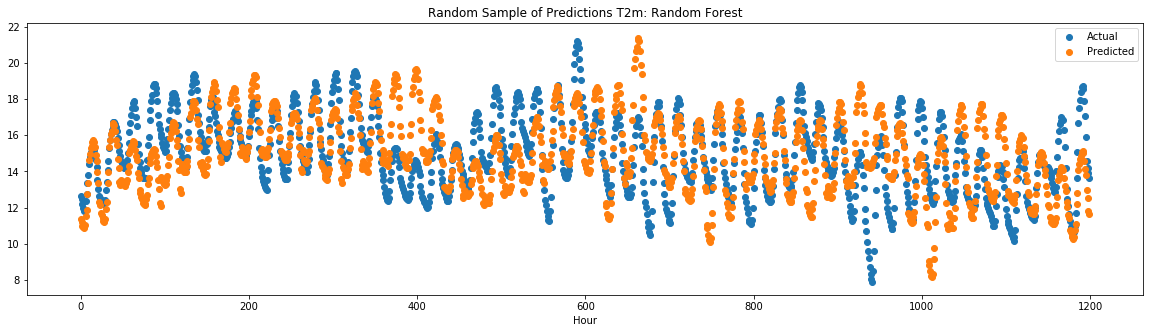

In [230]:
plt.scatter(np.arange(0,50*24,1),y_test.values[4000:4050])
plt.scatter(np.arange(0,50*24,1),pred_rf[4000:4050])
plt.xlabel("Hour")
plt.title("Random Sample of Predictions T2m: Random Forest")
plt.legend(["Actual","Predicted"])

### Gradient Boosted Trees

In [308]:
from sklearn.ensemble import RandomForestRegressor

gbt = RandomForestRegressor(n_estimators=100).fit(X_train,y_train)
pred_gbt = gbt.predict(X_test)

In [309]:
# metrics
r2_gbt = r2_score(y_test,pred_gbt)
mae_gbt = mean_absolute_error(y_test,pred_gbt)

print("R2-score: ",r2_gbt)
print("MAE-score: ",mae_gbt)

R2-score:  0.9811914244654739
MAE-score:  0.3871825040227603


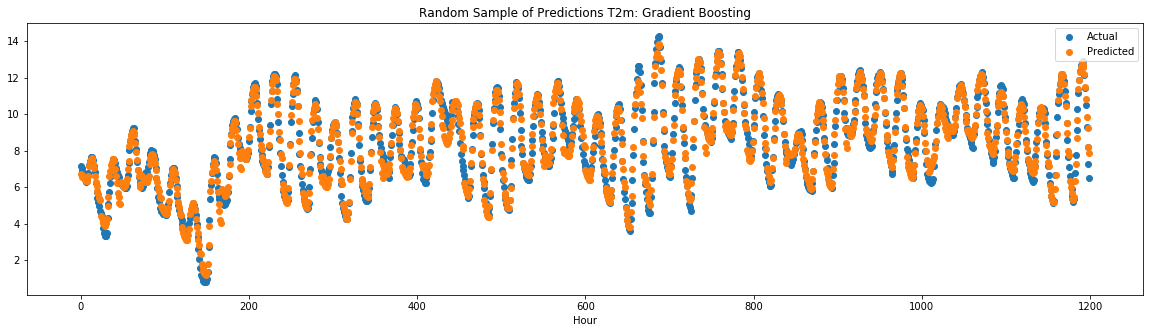

In [310]:
plt.scatter(np.arange(0,50*24,1),y_test.values[300:350])
plt.scatter(np.arange(0,50*24,1),pred_gbt[300:350])
plt.xlabel("Hour")
plt.title("Random Sample of Predictions T2m: Gradient Boosting")
plt.legend(["Actual","Predicted"])

### Analyze Best Performer

The best performer was Gradient Boosting. 

Below is a visual representation of the seasonal error.

Text(0, 0.5, 'MSE')

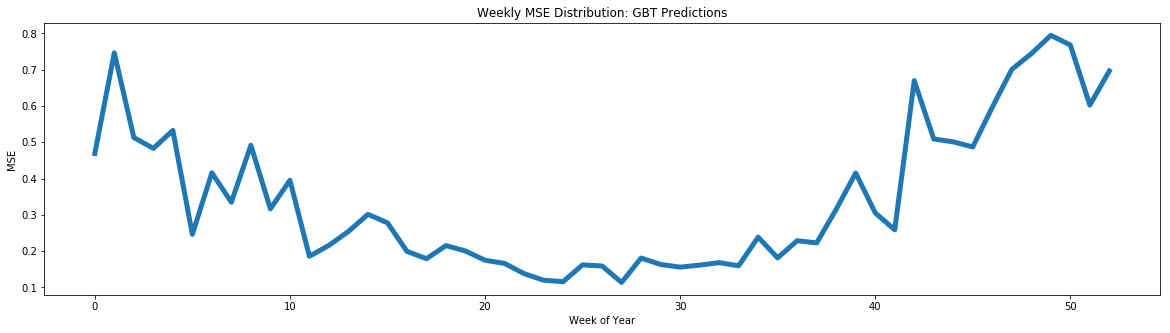

In [305]:
se = (pred_gbt - y_test)**2
se.index = pd.to_datetime(se.index)
mse_by_week = se.groupby(se.index.week).mean().mean(axis=1)
plt.plot(np.arange(0,53,1),mse_by_week.values.flatten(),linewidth=5)
plt.title("Weekly MSE Distribution: GBT Predictions")
plt.xlabel("Week of Year")
plt.ylabel("MSE")

Text(0, 0.5, 'MSE')

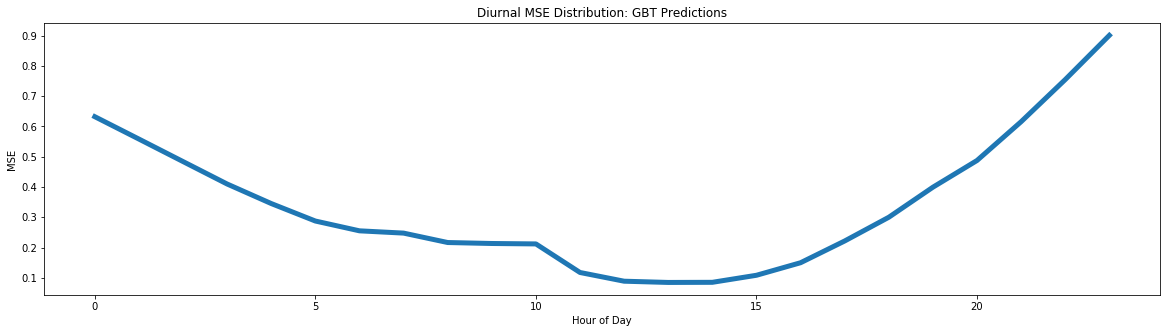

In [306]:
se = (pred_gbt - y_test)**2
se.index = pd.to_datetime(se.index)
mse_by_hour = se.groupby(se.index.hour).mean()
plt.plot(np.arange(0,24,1),mse_by_hour.values.flatten(),linewidth=5)
plt.title("Diurnal MSE Distribution: GBT Predictions")
plt.xlabel("Hour of Day")
plt.ylabel("MSE")

Found that winter weeks have higher MSE in comparison to summer months.

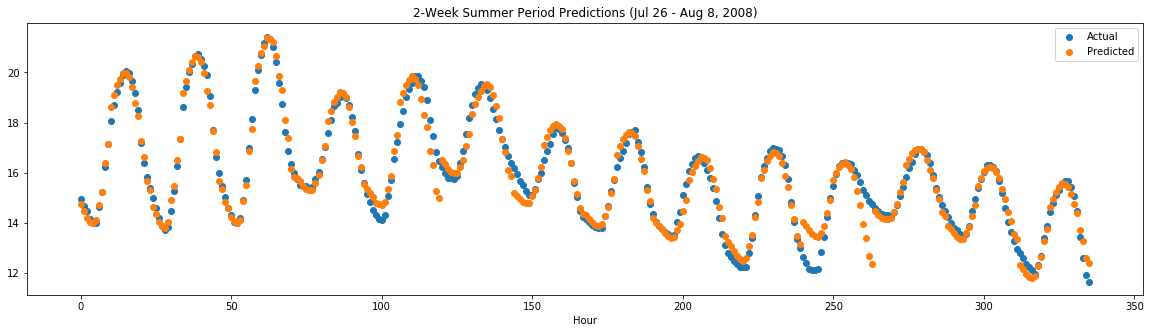

In [311]:
# generate summer/winter comparisons
y_d14_summer = y_test.iloc[60:74]
y_d14_winter = y_test.iloc[230:244]
pred_d14_summer = pred_gbt[60:74]
pred_d14_winter = pred_gbt[230:244]

plt.scatter(np.arange(0,14*24,1),y_d14_summer)
plt.scatter(np.arange(0,14*24,1),pred_d14_summer)
plt.xlabel("Hour")
plt.title("2-Week Summer Period Predictions (Jul 26 - Aug 8, 2008)")
plt.legend(["Actual","Predicted"])

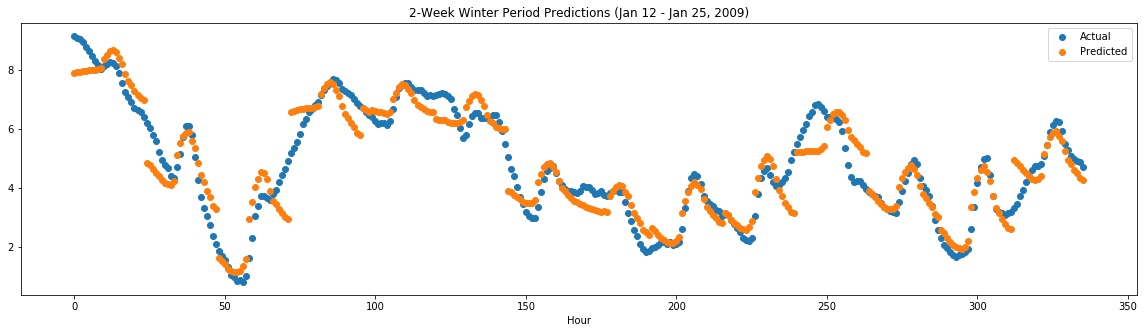

In [312]:
plt.scatter(np.arange(0,14*24,1),y_d14_winter)
plt.scatter(np.arange(0,14*24,1),pred_d14_winter)
plt.xlabel("Hour")
plt.title("2-Week Winter Period Predictions (Jan 12 - Jan 25, 2009)")
plt.legend(["Actual","Predicted"])

Clearly the model has issues with the extreme fluctuations of temperatures across the UK in the winter months, with predictions unable to capture the variability of the diurnal cycle. Summer months exhibit a more constant diurnal cycle with much better predictions.